<a href="https://colab.research.google.com/github/yj0905/2020/blob/master/lesson5_sgd_mnist_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    422      0 --:--:-- --:--:-- --:--:--   421
Updating fastai...
Done.


In [0]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [0]:
path = Config().data_path()/'mnist'

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/.ipynb_checkpoints'),
 PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1') #trainging, validation, test set

(50000, 784)

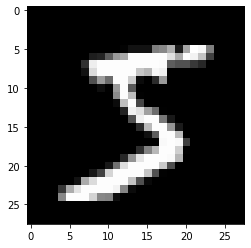

In [0]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape #28*28 pixel image로 재구성

In [0]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max() #tensor로

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs) #데이터세트 만들기

In [0]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module): #nn.module 만들기
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda() #로지스틱 회귀 모델

In [0]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape

torch.Size([64, 10])

In [0]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss() #교차 엔트로피 손실 함수

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x) #모델 직접 불러오기
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

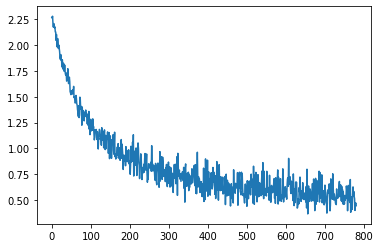

In [0]:
plt.plot(losses); #손실함수 그리기. 손실 감소하는 것을 볼 수 있다.

In [0]:
class Mnist_NN(nn.Module): #신경망 구축하기
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb) #lin1 통과
        x = F.relu(x) #ReLU 계산
        return self.lin2(x) #lin2

In [0]:
model = Mnist_NN().cuda() #cuda로 update function에 대한 loss 다시 계산.

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

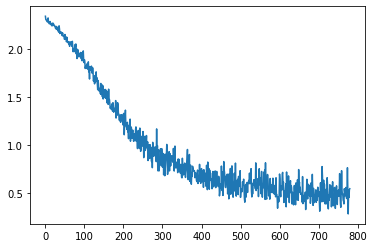

In [0]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr) #Adam 옵티마이저로 변경했을 때
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

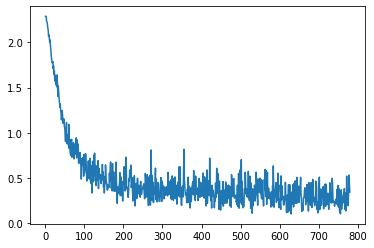

In [0]:
plt.plot(losses);

[Optimizer에 대한 간략한 정리](https://hyeonnii.tistory.com/232)

이 외에도 옵티마이저에 대한 여러 글들을 찾아보았으나 수학적으로 이해하려니 너무 어려웠습니다.

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy) #learn

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


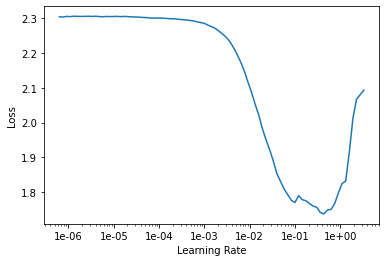

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.158305,0.124942,0.963900,00:03


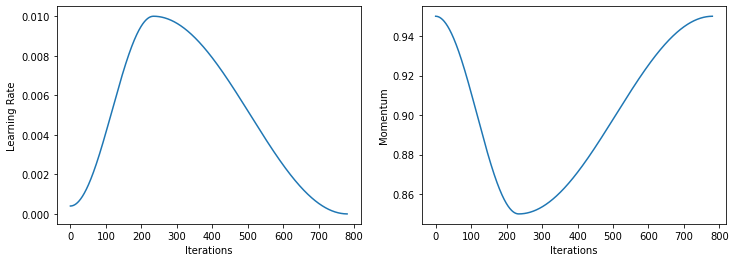

In [0]:
learn.recorder.plot_lr(show_moms=True)  #왼쪽: 학습률 오른쪽: 운동량

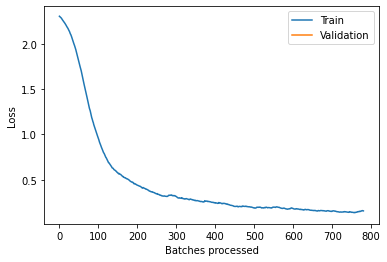

In [0]:
learn.recorder.plot_losses()

Fin